In [116]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt

In [117]:
# Baixa as entradas X.npy
!gdown https://drive.google.com/uc?id=1oSRay8phFA91RJoGH0tMmj86LBovKj73

# Baixa as saídas desejadas Y.npy
!gdown https://drive.google.com/uc?id=1_BQLcsgcYYsubtv4M80BVm4BEknrTOr7

Downloading...
From: https://drive.google.com/uc?id=1oSRay8phFA91RJoGH0tMmj86LBovKj73
To: /content/X.npy
33.8MB [00:00, 107MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1_BQLcsgcYYsubtv4M80BVm4BEknrTOr7
To: /content/Y.npy
100% 165k/165k [00:00<00:00, 5.21MB/s]


In [118]:
X = np.load('X.npy')
Y = np.load('Y.npy')

cats = [9,0,7,6,1,8,4,3,2,5]
Y[:,cats] = Y[:, range(10)]

In [119]:
def split_and_shuffle(X, Y, perc = 0.1):
  tot = len(X)
  indexes = np.arange(tot)
  np.random.shuffle(indexes)
  n = int((1 - perc)*tot)
  Xt = X[indexes[:n]]
  Yt = Y[indexes[:n]]
  Xv = X[indexes[n:]]
  Yv = Y[indexes[n:]]
  return Xt, Yt, Xv, Yv

In [120]:
Xt, Yt, Xv, Yv = split_and_shuffle(X, Y)

In [121]:

Xt = torch.from_numpy(Xt)
Yt = torch.from_numpy(Yt)
Xv = torch.from_numpy(Xv)
Yv = torch.from_numpy(Yv)

In [122]:
Xt = Xt.unsqueeze(1)
Xv = Xv.unsqueeze(1)

In [123]:
print('Dados de treinamento:')
print('Xt', Xt.size(), 'Yt', Yt.size())
print('Dados de validação:')
print('Xv', Xv.size(), 'Yv', Yv.size())

Dados de treinamento:
Xt torch.Size([1855, 1, 64, 64]) Yt torch.Size([1855, 10])
Dados de validação:
Xv torch.Size([207, 1, 64, 64]) Yv torch.Size([207, 10])


In [124]:
def show_sample(X, Y, n=3):
  ''' Essa função mostra algumas
      amostras aleatórias
  '''
  for i in range(n):
    k = np.random.randint(0,len(X))
    print('Mostrando', int(torch.argmax(Y[k,:])))
    plt.imshow(X[k,0,:,:], cmap='gray')
    plt.show()

Mostrando 4


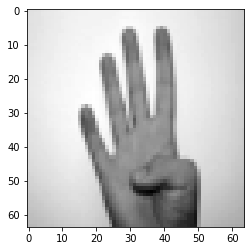

Mostrando 9


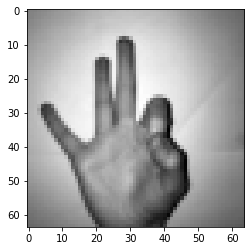

Mostrando 0


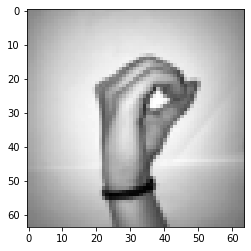

In [125]:
show_sample(Xt, Yt)

In [126]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=2, padding=0)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv2 = nn.Conv2d(in_channels=5, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.drp1 = nn.Dropout2d(0.25)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.lin1 = nn.Linear(in_features=288, out_features=10)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self, x, feature_collect=False):
    x = self.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.relu(self.conv2(x))
    x = self.drp1(x)
    x = self.pool2(x)
    x = self.flatten(x)
    if feature_collect:
      return x
    x = self.lin1(x) 
    return x

In [127]:
cnn = ConvNet()
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1))
  (drp1): Dropout2d(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=288, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [128]:
def evaluate(x, y_hat):
  y = cnn(x).argmax(dim=1)
  y_hat = y_hat.argmax(dim=1)
  return 100*float((y == y_hat).sum()) / len(y)

In [129]:
opt = optim.Adam(cnn.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [130]:
gpu = torch.device("cuda:0")
cnn = cnn.to(gpu)
Xt = Xt.to(gpu, dtype=torch.float)
Yt = Yt.to(gpu, dtype=torch.long)
Xv = Xv.to(gpu, dtype=torch.float)
Yv = Yv.to(gpu, dtype=torch.long)

In [131]:
epoch = 0
for j in range(3001):
  for i in range(0, len(Yt), 128):
    x = Xt[i:i+128, :, :, :]
    y_hat = Yt[i:i+128, :].argmax(dim=1)
    opt.zero_grad()
    y = cnn(x)
    err = criterion(y, y_hat)
    err.backward()
    opt.step()

  if not (j % 200):
    print("Epoch:", epoch, "Loss:", float(err), "Accuracy:", evaluate(Xt, Yt))
    epoch += 1

Epoch: 0 Loss: 2.3119559288024902 Accuracy: 10.889487870619947
Epoch: 1 Loss: 0.7528162002563477 Accuracy: 80.0
Epoch: 2 Loss: 0.36169198155403137 Accuracy: 85.33692722371967
Epoch: 3 Loss: 0.2633717954158783 Accuracy: 88.03234501347708
Epoch: 4 Loss: 0.20439499616622925 Accuracy: 89.43396226415095
Epoch: 5 Loss: 0.16827334463596344 Accuracy: 90.5121293800539
Epoch: 6 Loss: 0.18520592153072357 Accuracy: 91.48247978436657
Epoch: 7 Loss: 0.21110478043556213 Accuracy: 92.45283018867924
Epoch: 8 Loss: 0.09143005311489105 Accuracy: 92.722371967655
Epoch: 9 Loss: 0.11326155066490173 Accuracy: 93.58490566037736
Epoch: 10 Loss: 0.14659865200519562 Accuracy: 93.47708894878706
Epoch: 11 Loss: 0.13340894877910614 Accuracy: 92.83018867924528
Epoch: 12 Loss: 0.04678020253777504 Accuracy: 94.50134770889488
Epoch: 13 Loss: 0.10422740131616592 Accuracy: 93.20754716981132
Epoch: 14 Loss: 0.0673445388674736 Accuracy: 93.26145552560646
Epoch: 15 Loss: 0.08354297280311584 Accuracy: 94.50134770889488


In [132]:
cnn.eval()

ConvNet(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1))
  (drp1): Dropout2d(p=0.25, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=288, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [133]:
ac = evaluate(Xv, Yv)
print('Acurácia de', ac, '%')

Acurácia de 85.02415458937197 %


In [134]:
def random_sample_cnn(X, Y):
  for _ in range(5):
    idx = np.random.randint(0, len(Yv))
    x = Xv[idx:idx+1,:,:,:]
    y = int(cnn(x).argmax(dim=1))
    y_hat = int(Yv[idx:idx+1,:].argmax(dim=1))
    print('y =', y, 'y_hat =', y_hat)
    x = x.cpu()
    plt.imshow(x[0,0,:,:], cmap='gray')
    plt.show()

y = 7 y_hat = 7


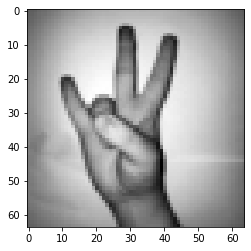

y = 4 y_hat = 4


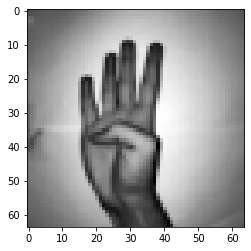

y = 1 y_hat = 1


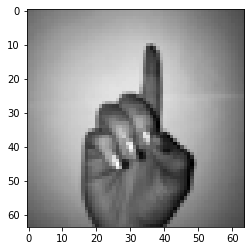

y = 9 y_hat = 9


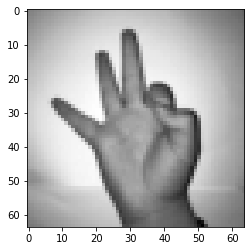

y = 2 y_hat = 2


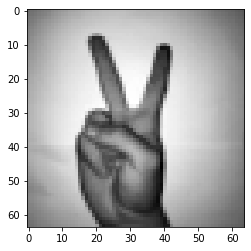

In [135]:
random_sample_cnn(Xv, Yv)

In [146]:
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from numpy import unique, where, array
from sklearn.decomposition import PCA

In [147]:
def do_pca(n_components, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [148]:
new_X = (cnn(Xv[0:100,:,:,:], feature_collect=True))

In [149]:
X = array(new_X.cpu().detach().numpy())
pca, X = do_pca(2, X)

Original


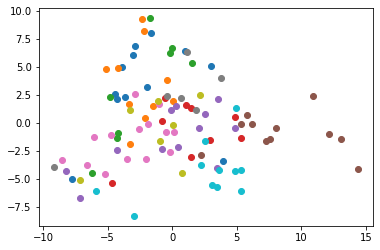

In [150]:
print("Original")
y = Yv[0:100, :].cpu().detach().numpy()
yhat = list()
for yh in y:
  yhat.append(np.argmax(yh))
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	plt.scatter(X[row_ix, 0], X[row_ix, 1])

Clustering features with K-Means


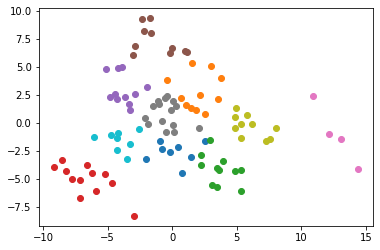

In [151]:
# k-means clustering
model = KMeans(n_clusters=10)
model.fit(X)
yhat = model.predict(X)
clusters = unique(yhat)
for cluster in clusters:
	row_ix = where(yhat == cluster)
	plt.scatter(X[row_ix, 0], X[row_ix, 1])

print("Clustering features with K-Means")
plt.show()

Clustering features with agglomerative


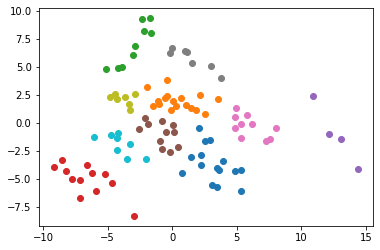

In [152]:
# agglomerative clustering
model = AgglomerativeClustering(n_clusters=10)
yhat = model.fit_predict(X)
clusters = unique(yhat)
for cluster in clusters:
	row_ix = where(yhat == cluster)
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
 
print("Clustering features with agglomerative")
plt.show()

Clustering features with dbscan


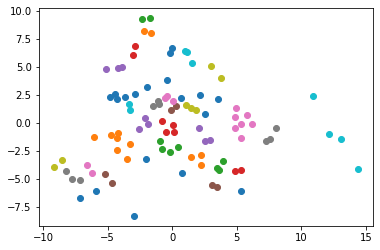

In [155]:
# OPTICS clustering
model = OPTICS(eps=0.3, min_samples=2)
yhat = model.fit_predict(X)
clusters = unique(yhat)
for cluster in clusters:
	row_ix = where(yhat == cluster)
	plt.scatter(X[row_ix, 0], X[row_ix, 1])
 
print("Clustering features with dbscan")
plt.show()